In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 

In [102]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [103]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [104]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [105]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [106]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [108]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [109]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))
"""
y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [110]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [111]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [112]:
model = Model(inputs=input_layer, outputs=output_layer)

In [113]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [115]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_frequency,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - R2Score: 0.6707 - loss: 0.3219 - val_R2Score: 0.9132 - val_loss: 0.0772
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.8953 - loss: 0.1129 - val_R2Score: 0.9281 - val_loss: 0.0640
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.9211 - loss: 0.0820 - val_R2Score: 0.9421 - val_loss: 0.0515
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9366 - loss: 0.0620 - val_R2Score: 0.9445 - val_loss: 0.0493
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9400 - loss: 0.0673 - val_R2Score: 0.9477 - val_loss: 0.0465
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9368 - loss: 0.0668 - val_R2Score: 0.9536 - val_loss: 0.0413
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9518 - loss: 0.0509 - val_R2Score: 0.9507 - val_loss: 0.0438
Epoch 8/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9542 - loss: 0.0498 - val_R2Score: 0.9561 -

In [116]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_frequency)
print('Test accuracy:', test_mse)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: 0.9800 - loss: 0.0229
Test accuracy: 0.9796707630157471


In [117]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,421 (861.02 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,948 (574.02 KB)

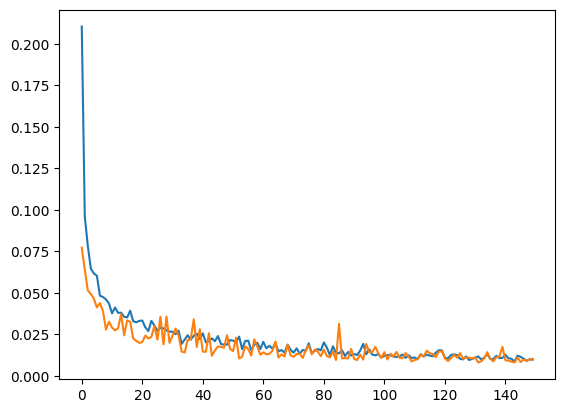

In [118]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [119]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_frequency.inverse_transform((predictions_scaled))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [120]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
           0
0  93.741791
1  34.955055
2  11.126504
3  31.743404
4   9.620611


In [121]:
y_test["frequency"]

3001     91.4822
5829     32.4879
11774    11.8316
8374     31.8855
8203      9.5643
          ...   
11314     7.0697
2055     23.7930
5693     15.7452
6551      4.3574
5993      6.3673
Name: frequency, Length: 2493, dtype: float64

In [122]:
true= y_test["frequency"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

8.560158938137764

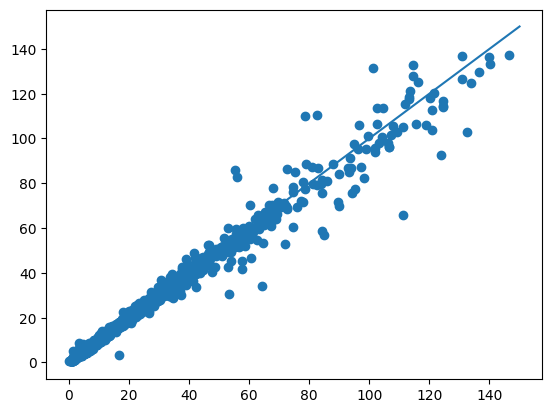

In [123]:
x=predictions_df
y=y_test["frequency"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 150],[0, 150])
plt.show()

In [124]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(32, activation='relu')(dropout2)

# Separate output for each target variable
output_layer = Dense(1)(hidden3)
#, name='allowable_deformation'

In [125]:
model_d = Model(inputs=input_layer, outputs=output_layer)

In [126]:
model_d.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [127]:
history_d = model_d.fit(
    x_train_transformed, 
    y_train_transformed_allowable_deformation,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - R2Score: 0.5013 - loss: 0.4137 - val_R2Score: 0.9184 - val_loss: 0.0802
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9034 - loss: 0.1042 - val_R2Score: 0.9408 - val_loss: 0.0581
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.8926 - loss: 0.1007 - val_R2Score: 0.9435 - val_loss: 0.0555
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.9165 - loss: 0.0819 - val_R2Score: 0.8959 - val_loss: 0.1022
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: 0.9216 - loss: 0.0782 - val_R2Score: 0.9527 - val_loss: 0.0464
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9368 - loss: 0.0605 - val_R2Score: 0.9655 - val_loss: 0.0338
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9364 - loss: 0.0625 - val_R2Score: 0.9620 - val_loss: 0.0373
Epoch 8/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9285 - loss: 0.0775 - val_R2Score: 0.9632 - v

In [128]:
test_loss, test_mse = model_d.evaluate(x_test_transformed, y_test_transformed_allowable_deformation)
print('Test accuracy:', test_mse)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2Score: 0.9758 - loss: 0.0181
Test accuracy: 0.975639820098877


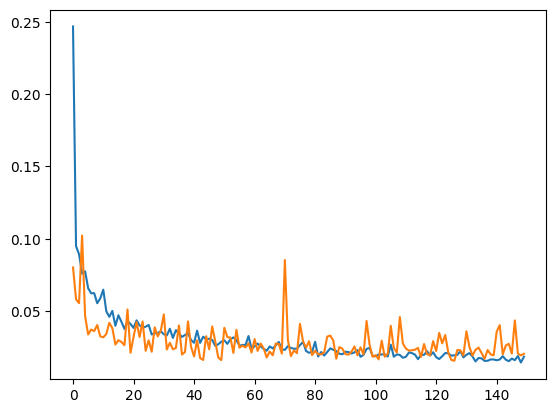

In [129]:
plt.plot(history_d.history["loss"],label="loss")
plt.plot(history_d.history["val_loss"],label="val_loss")

In [130]:
predictions_scaled_d = model_d.predict(x_test_transformed)
predictions_d = scaler_y_allowable_deformation.inverse_transform((predictions_scaled_d))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [131]:
predictions_df_d = pd.DataFrame(predictions_d)
print("\nSample Predictions:")
print(predictions_df_d)


Sample Predictions:
               0
0       3.989085
1      37.961983
2       6.958448
3       4.366268
4       6.500721
...          ...
2488    9.183923
2489    1.511432
2490   13.663976
2491   14.844579
2492  142.220352

[2493 rows x 1 columns]


In [132]:
y_test["allowable_deformation"]

3001       1.501
5829      45.212
11774      5.879
8374       2.805
8203       3.807
          ...   
11314      9.450
2055       1.185
5693       6.914
6551      21.747
5993     134.567
Name: allowable_deformation, Length: 2493, dtype: float64

In [136]:
true= y_test["allowable_deformation"].tolist()
pred_d= predictions_df_d[0].tolist()
mean_squared_error(true,pred_d)

139.07913015425723

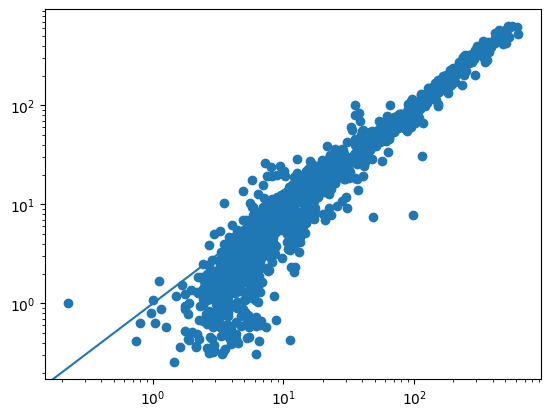

In [137]:
x=predictions_df_d
y=y_test["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
plt.plot([0, 600],[0, 600])
plt.show()

[]

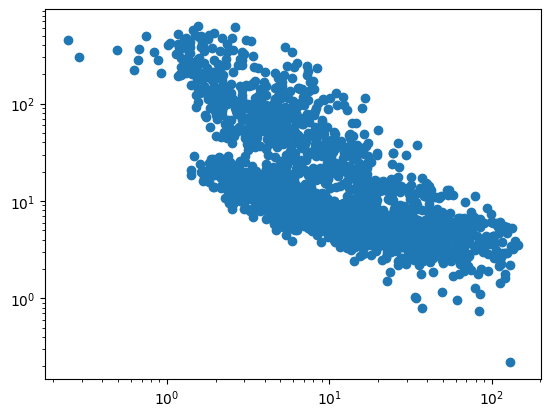

In [139]:
y=predictions_df_d
x=predictions_df
plt.scatter(x,y)
plt.loglog()